In [31]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score,silhouette_samples
import matplotlib.cm as cm
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
import seaborn as sns

from sklearn.decomposition import PCA
from ucimlrepo import fetch_ucirepo
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.cluster import hierarchy
from sklearn.cluster import AgglomerativeClustering


from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix, classification_report

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

In [32]:
heart_disease = fetch_ucirepo(id=45)

In [33]:
df = heart_disease.data.original
df.head(3)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1


1. Predict the presence of heart disease in the patients based on personal features (such as `sex` and `age`) and medical features.

2.   The `ca` variable is right-skewed with a high percentage of 0. Additionally, the violin plot shows that patients without heart disease  (`num = 0`) are concentrated in `ca = 0`.
We treat it as a categorical variable to avoid issues in following steps that use models sensitivity to feature scaling. (This imbalance can not be solved by StandardScaler or log transfomation since the range of `ca` is only integer 0 to 3.)

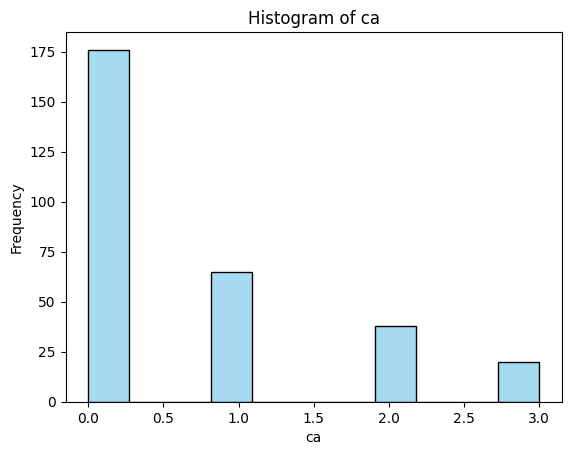

In [34]:
sns.histplot(
    data=df,
    x = 'ca',
    color='skyblue',
    edgecolor='black'
)

plt.title('Histogram of ca')
plt.xlabel('ca')
plt.ylabel('Frequency')
plt.show()

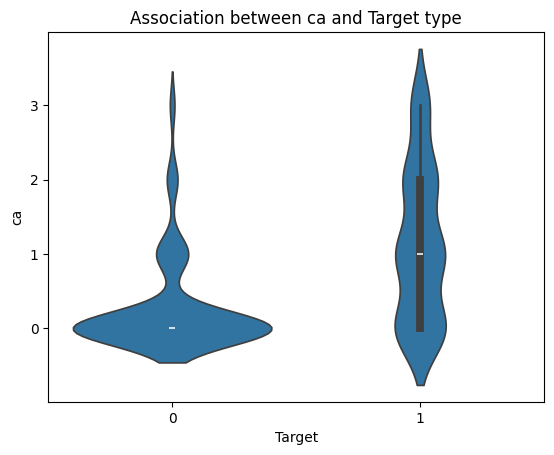

In [35]:
df_transfer = df.copy()
df_transfer['target'] = df_transfer['num'].apply(lambda x: 1 if x > 0 else 0)
sns.violinplot(x='target', y='ca', data=df_transfer)
plt.xlabel('Target')
plt.ylabel('ca')
plt.title('Association between ca and Target type')
plt.show()

The `oldpeak` variable is right-skewed, indicating that a log transformation could help normalize the distribution. However, since this variable contains many zero values, a small pseudo-value (e.g., 0.001) should be added to the oldpeak before applying the transformation to avoid taking the logarithm of zero.

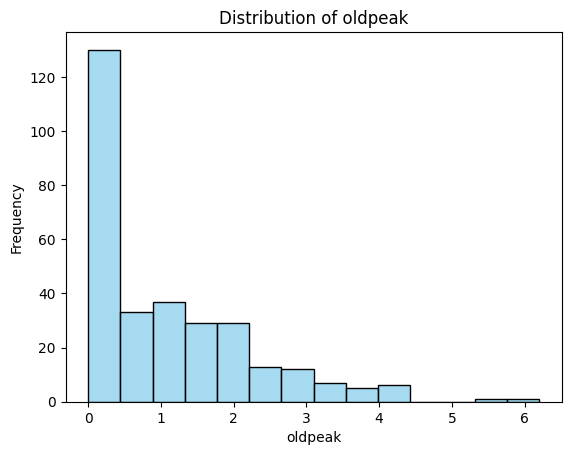

In [36]:
sns.histplot(
    data=df,
    x = 'oldpeak',
    color='skyblue',
    edgecolor='black'
)


plt.title('Distribution of oldpeak')
plt.xlabel('oldpeak')
plt.ylabel('Frequency')
plt.show()

In [37]:
df['oldpeak'] = np.log(df['oldpeak'] + 1)

3.

Variables & data types (based on dtype function & variable description):

Numerical: age, trestbps, chol,thalach,oldpeak

Categorical: sex, cp, fbs, restecg, exang, slope, thal, and ca

Target variable is num which is categorical.

distribution of target variable: The dataset has 164 observations of patients with heart disease (num=0) and 139 observations of patients without haert disease (num>0). (55 with num = 1, 36 with num = 2, 35 with num = 3, and 13 with num = 4.)

Number of obs: There are total 303 observations(rows) and 14 kay variables(columns) in this dataset.

In [38]:
df.shape

(303, 14)

In [39]:
var_inf = heart_disease.variables
print(var_inf)

        name     role         type demographic  \
0        age  Feature      Integer         Age   
1        sex  Feature  Categorical         Sex   
2         cp  Feature  Categorical        None   
3   trestbps  Feature      Integer        None   
4       chol  Feature      Integer        None   
5        fbs  Feature  Categorical        None   
6    restecg  Feature  Categorical        None   
7    thalach  Feature      Integer        None   
8      exang  Feature  Categorical        None   
9    oldpeak  Feature      Integer        None   
10     slope  Feature  Categorical        None   
11        ca  Feature      Integer        None   
12      thal  Feature  Categorical        None   
13       num   Target      Integer        None   

                                          description  units missing_values  
0                                                None  years             no  
1                                                None   None             no  
2              

In [40]:
df.dtypes

age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca          float64
thal        float64
num           int64
dtype: object

In [41]:
df['num'].value_counts()

num
0    164
1     55
2     36
3     35
4     13
Name: count, dtype: int64

In [42]:
cat_col = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal', 'ca']
num_col = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
df[num_col].describe()

,age,trestbps,chol,thalach,oldpeak
count,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.438944,131.689769,246.693069,149.607261,0.569944
std,9.038662,17.599748,51.776918,22.875003,0.524336
min,29.000000,94.000000,126.000000,71.000000,0.000000
25%,48.000000,120.000000,211.000000,133.500000,0.000000
50%,56.000000,130.000000,241.000000,153.000000,0.587787
75%,61.000000,140.000000,275.000000,166.000000,0.955511
max,77.000000,200.000000,564.000000,202.000000,1.974081


4

In [43]:
df['num'] = df['num'].apply(lambda x: 1 if x > 0 else 0)
df['num'].nunique()

2

5.


*   Heatmap shows correlation between numerical variables. The numberical variables have no significant correlation (>0.5) where affect feature selection.
*   The boxplot of `oldpeak` vs `slope` shows significant differences in the distribution of `oldpeak` across different slope categories. Similarly, the boxplot of `oldpeak` vs `restecg` shows significant higher `oldpeak` in `restecg` category value 1.  After evaluating feature importance in following steps, we may drop `oldpeak` if it is not importance to reduce multicollinearity.

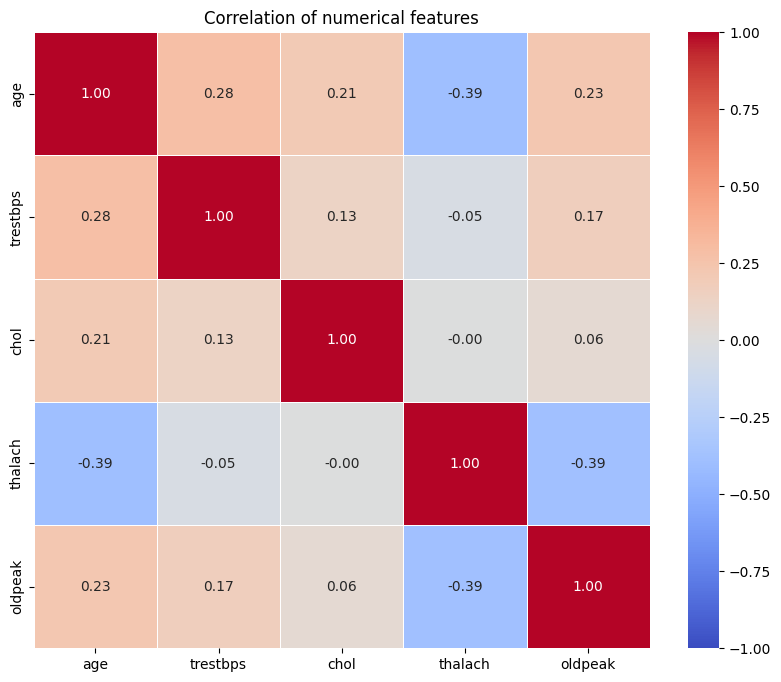

In [44]:
numerical_vars = df[num_col]
scaler = StandardScaler()
numerical_vars_scaled = pd.DataFrame(scaler.fit_transform(numerical_vars), columns=numerical_vars.columns)
corr_matrix = numerical_vars_scaled.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix,vmin=-1, vmax=1, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5)

plt.title('Correlation of numerical features')
plt.show()

<Axes: xlabel='restecg', ylabel='oldpeak'>

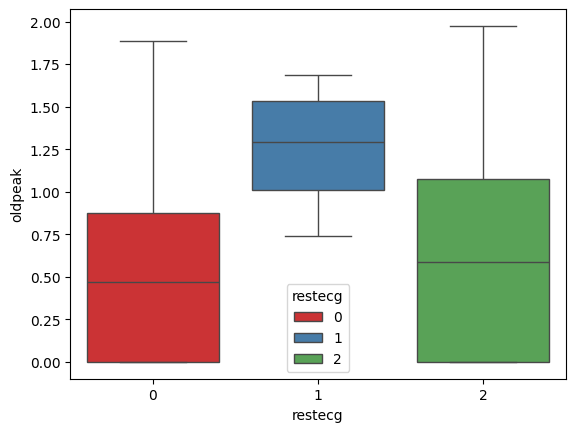

In [45]:
sns.boxplot(
    x = 'restecg',
    y = 'oldpeak',
    data=df,
    hue='restecg',
    palette='Set1'
)

<Axes: xlabel='slope', ylabel='oldpeak'>

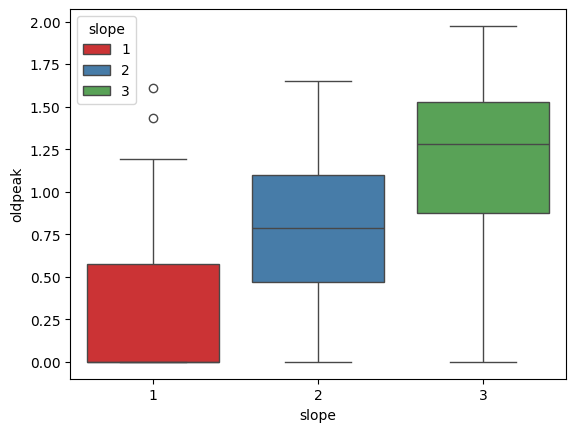

In [46]:
sns.boxplot(
    x = 'slope',
    y = 'oldpeak',
    data=df,
    hue='slope',
    palette='Set1'
)

6. 
There are 297 obs after dropping the missing values.

In [47]:
df.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
num         0
dtype: int64

In [48]:
df=df.dropna()
print(df.shape)

(297, 14)


In [49]:
df.isna().sum().sum()

np.int64(0)

7

In [50]:
# select numerical columns
clust_df = df[num_col]
print(clust_df.head())

   age  trestbps  chol  thalach   oldpeak
0   63       145   233      150  1.193922
1   67       160   286      108  0.916291
2   67       120   229      129  1.280934
3   37       130   250      187  1.504077
4   41       130   204      172  0.875469


In [51]:
scaler = StandardScaler()
clust_df_scaled = scaler.fit_transform(clust_df)
clust_df_scaled = pd.DataFrame(clust_df_scaled, columns=clust_df.columns)
print(clust_df_scaled.head())

        age  trestbps      chol   thalach   oldpeak
0  0.936181  0.750380 -0.276443  0.017494  1.174672
1  1.378929  1.596266  0.744555 -1.816334  0.645463
2  1.378929 -0.659431 -0.353500 -0.899420  1.340529
3 -1.941680 -0.095506  0.051047  1.633010  1.765876
4 -1.498933 -0.095506 -0.835103  0.978071  0.567650


In [52]:
pca_model = PCA()
df_pca = pd.DataFrame(pca_model.fit_transform(clust_df_scaled))

In [53]:
pd.DataFrame([df_pca.iloc[:,:5].std(axis=0, ddof=0).to_numpy(),
              pca_model.explained_variance_ratio_[:5],
              np.cumsum(pca_model.explained_variance_ratio_[:5])],
             index=['Standard deviation', 'Proportion of variance', 'Cumulative proportion'],
             columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])

,PC1,PC2,PC3,PC4,PC5
Standard deviation,1.352807,1.052539,0.927735,0.858168,0.681858
Proportion of variance,0.366017,0.221567,0.172138,0.147290,0.092986
Cumulative proportion,0.366017,0.587585,0.759723,0.907014,1.000000


We use first 3 PCs with over 75% variance explained.

In [54]:
Xpcs = df_pca.iloc[:,:3]

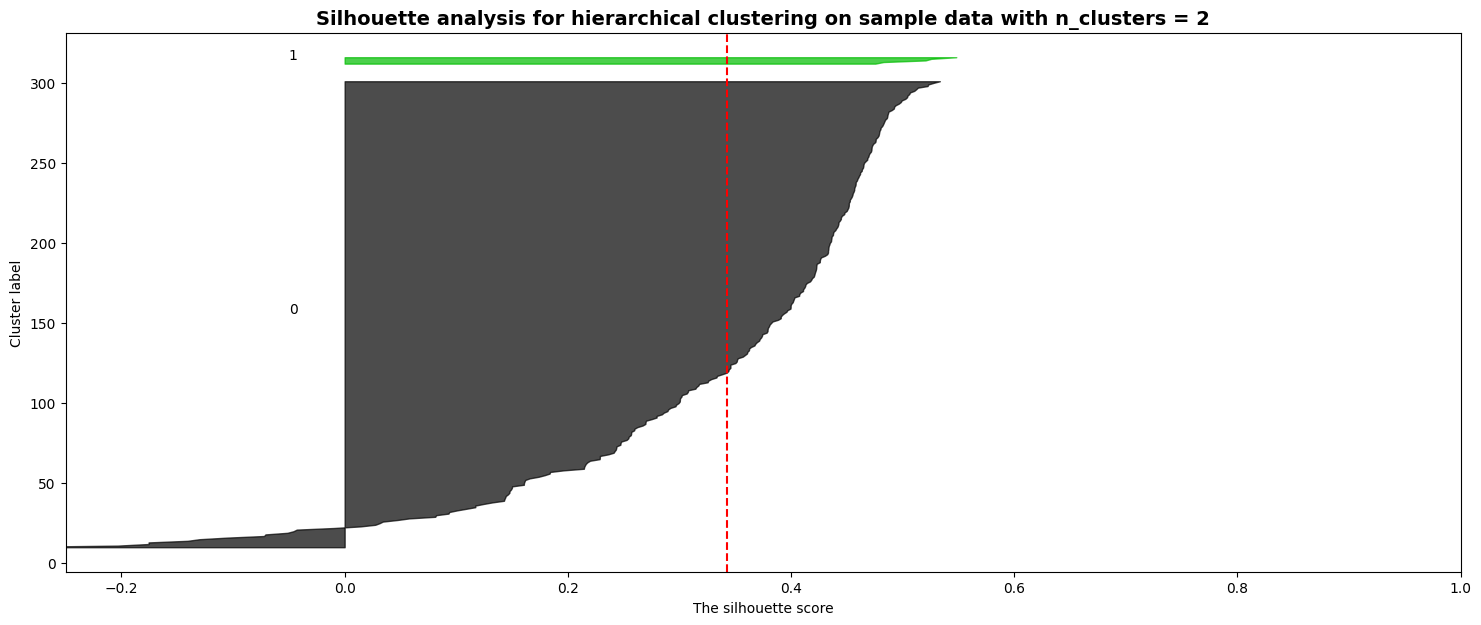

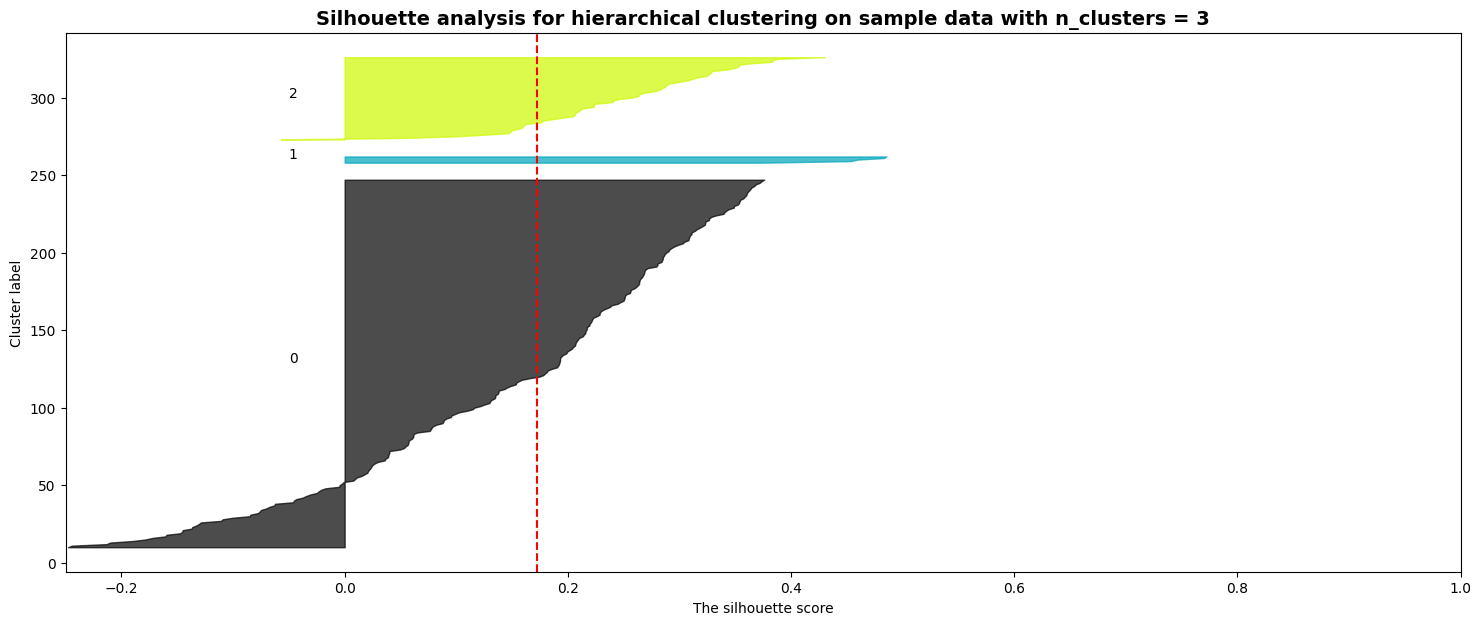

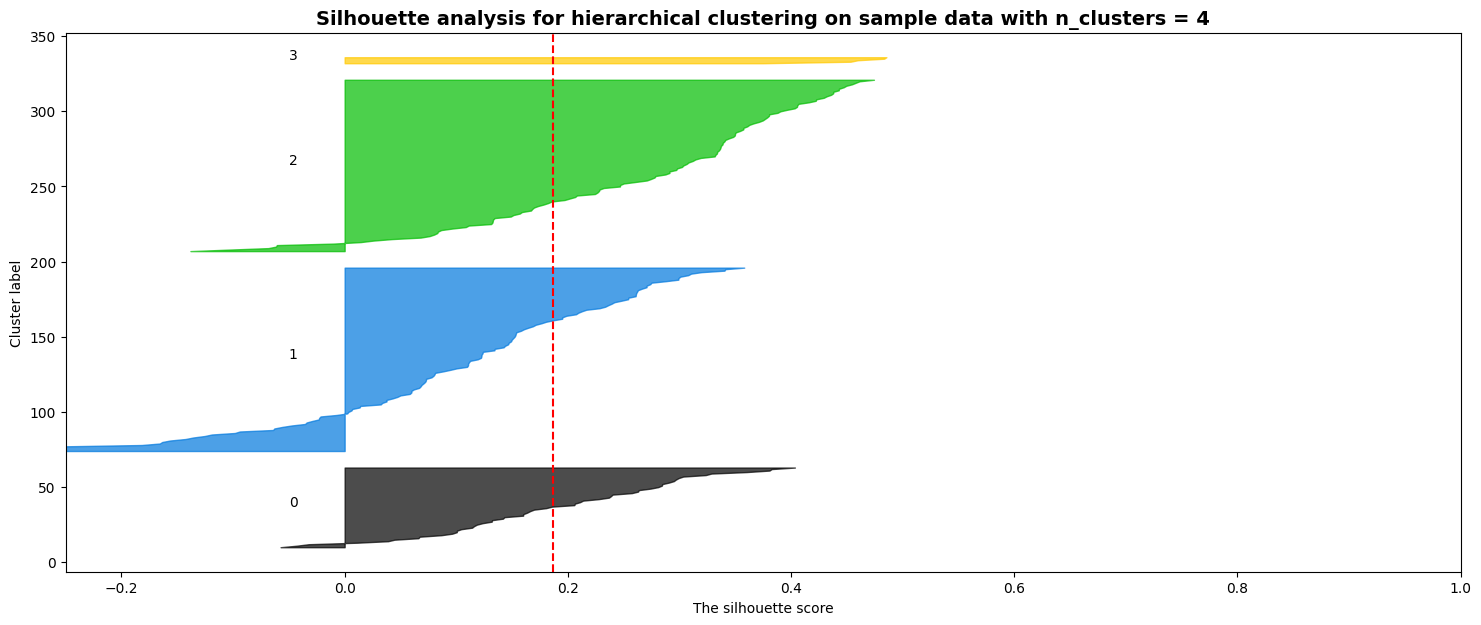

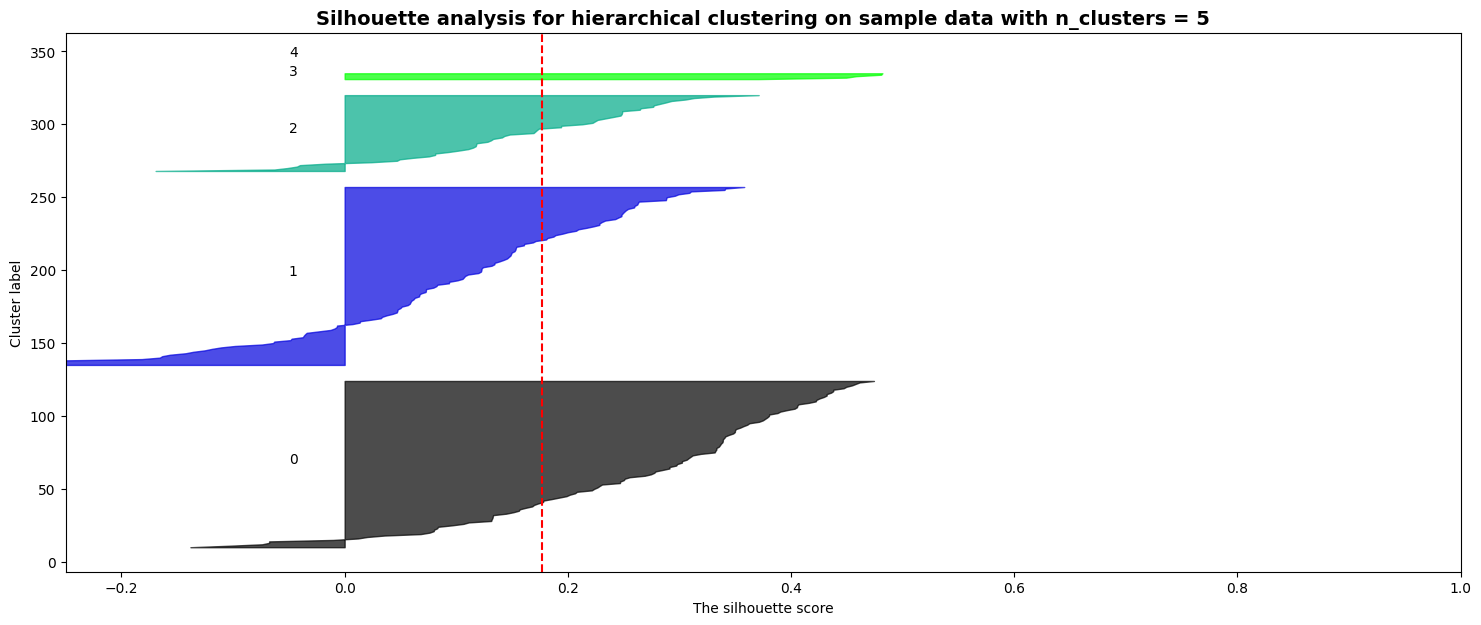

In [55]:
# hierarchical clustering
range_n_clusters = [2,3,4,5]
for n_clusters in range_n_clusters:
    model_hc = AgglomerativeClustering(linkage="complete", n_clusters=n_clusters)
    model_hc.fit(Xpcs)
    silhouette_avg_hc = silhouette_score(clust_df_scaled, model_hc.labels_)
    # compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(
        clust_df_scaled,
        model_hc.labels_
        )
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)
    ax1.set_xlim([-0.25, 1])# change this based on the silhouette range

    y_lower = 10

    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[model_hc.labels_ == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # compute the new y_lower for next plot
        y_lower = y_upper + 10

    ax1.set_title("The silhouette plot for various cluster")
    ax1.set_xlabel("The silhouette score")
    ax1.set_ylabel("Cluster label")

    # vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg_hc, color="red", linestyle="--")
    plt.title(
        "Silhouette analysis for hierarchical clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

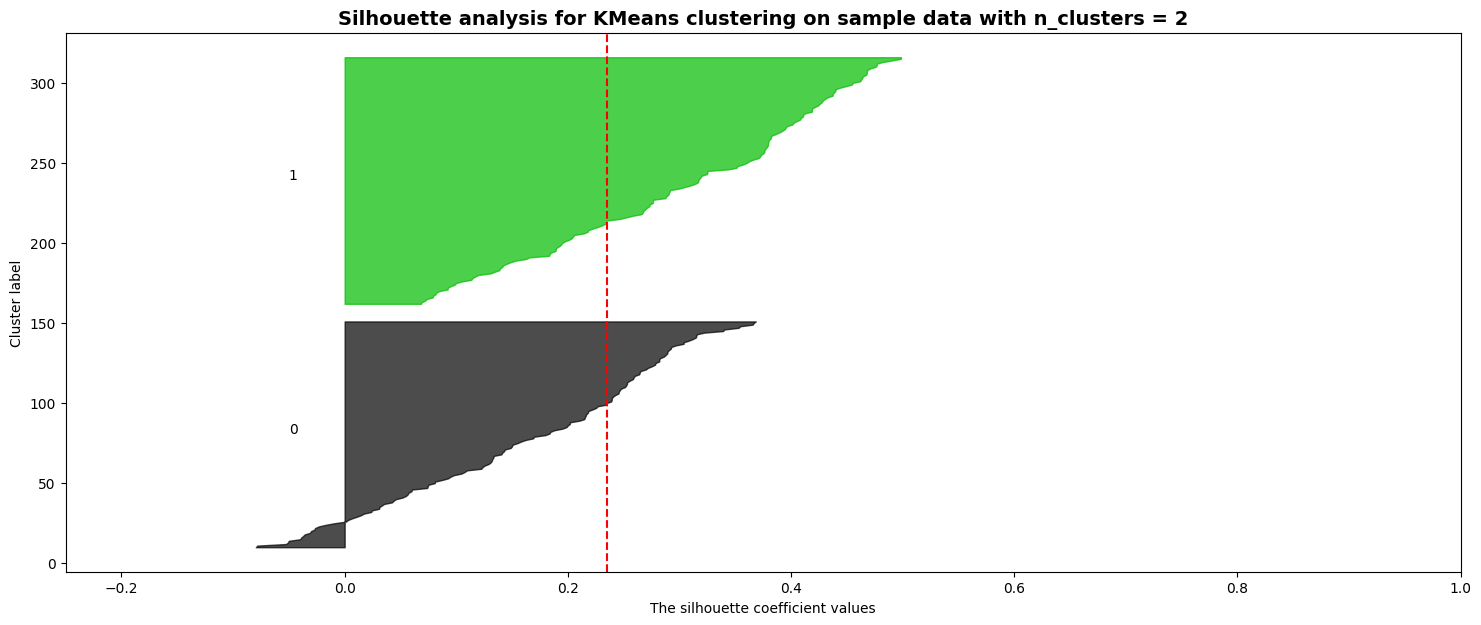

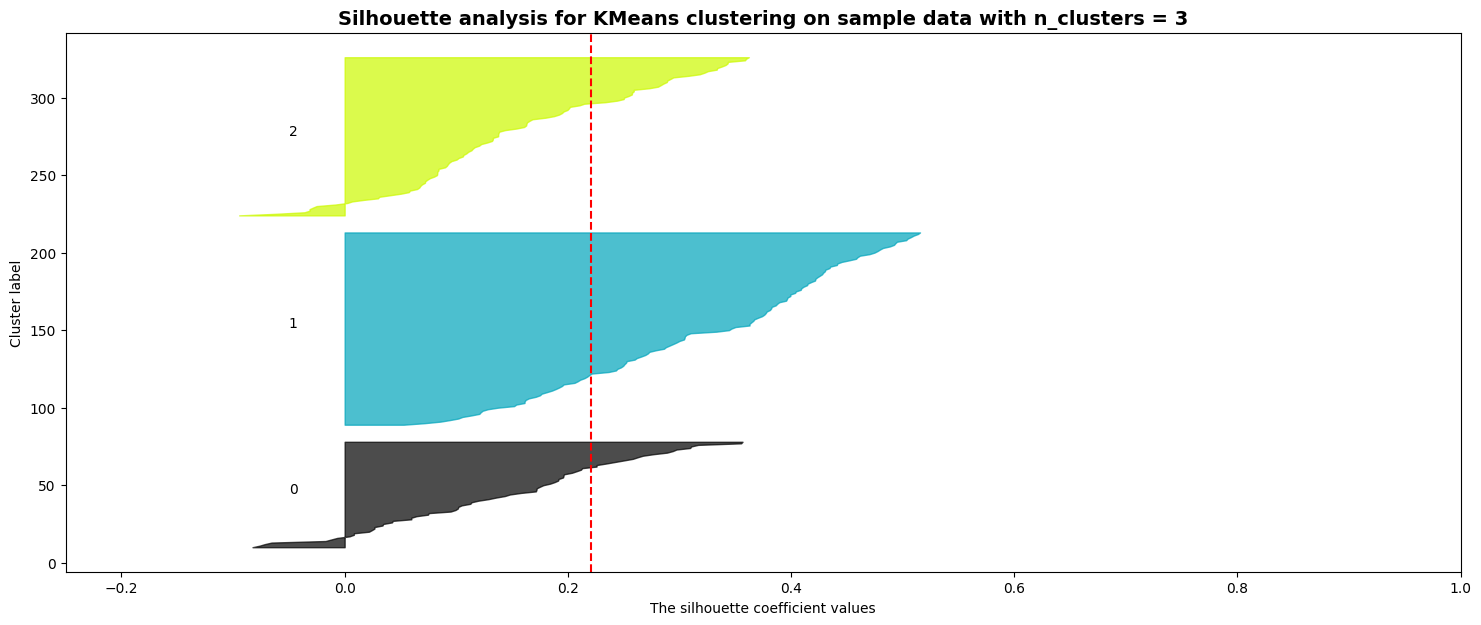

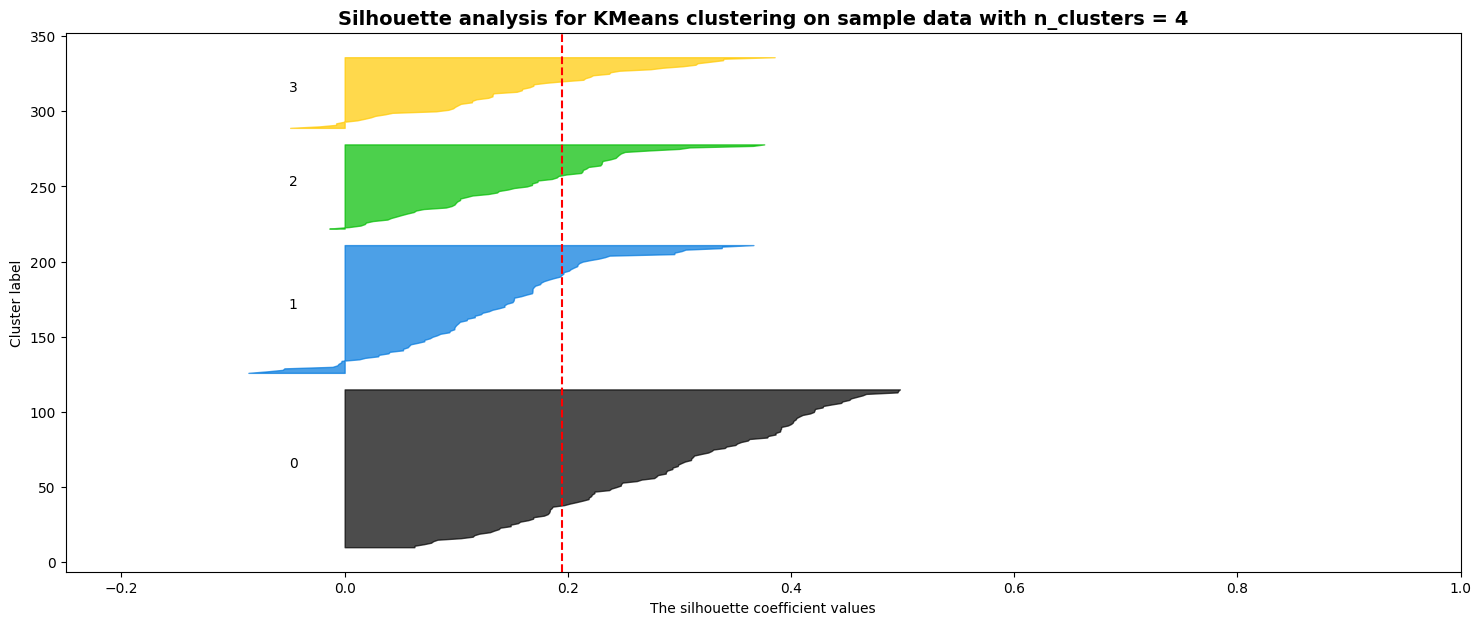

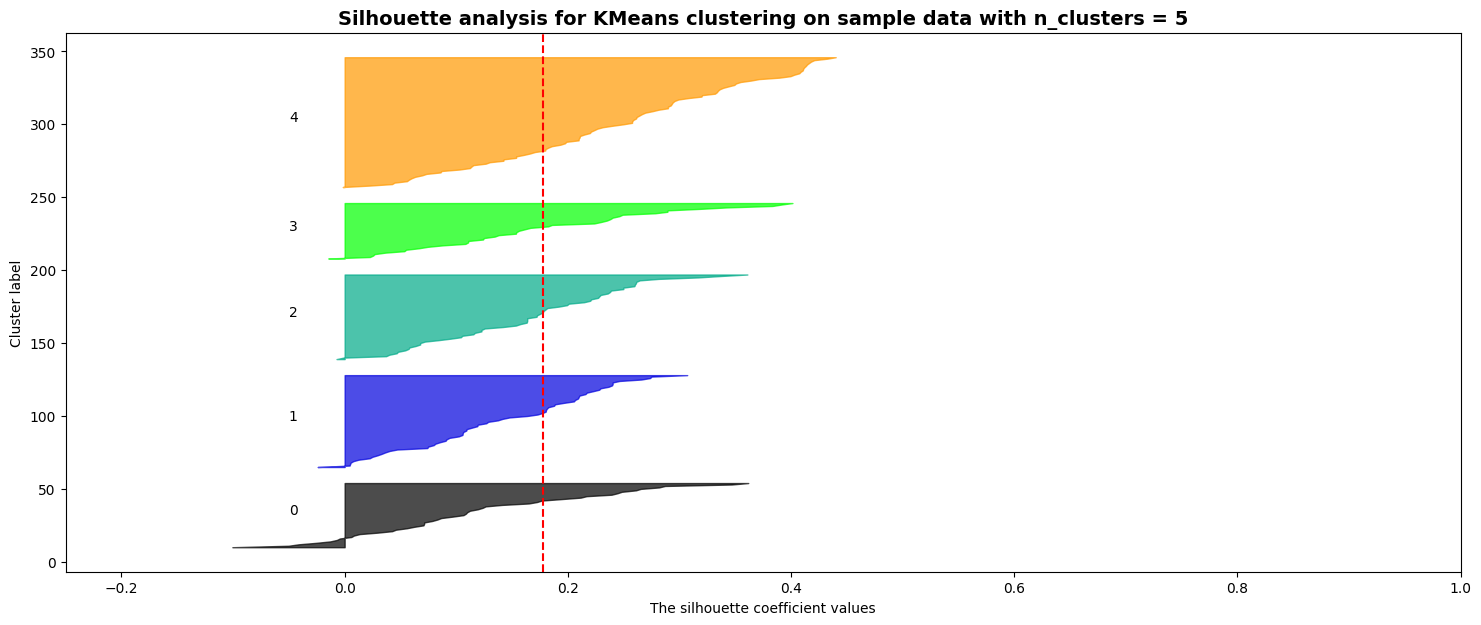

In [56]:
# kmeans
range_n_clusters = range(2,6)
for n_clusters in range_n_clusters:
    km = KMeans(n_clusters = n_clusters, n_init = 20, random_state=0)
    cluster_labels_km = km.fit_predict(Xpcs)
    silhouette_avg_km = silhouette_score(clust_df_scaled, cluster_labels_km)
    # compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(clust_df_scaled, cluster_labels_km)
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)
    ax1.set_xlim([-0.25, 1])# change this based on the silhouette range

    y_lower = 10

    for i in range(n_clusters):
        # aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels_km == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # compute the new y_lower for next plot
        y_lower = y_upper + 10

    ax1.set_title("The silhouette plot for various cluster")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg_km, color="red", linestyle="--")
    plt.title(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

It seems 2 clusters hierarchical clustering is a good fit since the highest average silhouette score (> 0.3) and a relatively low number of negative silhouette values.

In [57]:
# create a new dataset df_cluster for Qeustion 15

hc2 = AgglomerativeClustering(linkage="complete", n_clusters=2)
hc2.fit(Xpcs)
df_cluster = df.copy()
df_cluster['cluster'] = hc2.labels_
df_cluster['cluster'] = df_cluster['cluster'].astype('category')

8

In [58]:
# one-hot encode categorical variables and drop one level
df_dummies = pd.get_dummies(df, columns=cat_col, drop_first=True, dtype=int)
print(df_dummies.head())
X = df_dummies.drop(columns = ['num'])
y = df_dummies['num']

   age  trestbps  chol  thalach   oldpeak  num  sex_1  cp_2  cp_3  cp_4  ...  \
0   63       145   233      150  1.193922    0      1     0     0     0  ...   
1   67       160   286      108  0.916291    1      1     0     0     1  ...   
2   67       120   229      129  1.280934    1      1     0     0     1  ...   
3   37       130   250      187  1.504077    0      1     0     1     0  ...   
4   41       130   204      172  0.875469    0      0     1     0     0  ...   

   restecg_1  restecg_2  exang_1  slope_2  slope_3  thal_6.0  thal_7.0  \
0          0          1        0        0        1         1         0   
1          0          1        1        1        0         0         0   
2          0          1        1        1        0         0         1   
3          0          0        0        0        1         0         0   
4          0          1        0        0        0         0         0   

   ca_1.0  ca_2.0  ca_3.0  
0       0       0       0  
1       0       0 

In [59]:
# scale the numerical variables
scaler = StandardScaler()
X[num_col] = scaler.fit_transform(X[num_col])
print(X.head(3))

        age  trestbps      chol   thalach   oldpeak  sex_1  cp_2  cp_3  cp_4  \
0  0.936181  0.750380 -0.276443  0.017494  1.174672      1     0     0     0   
1  1.378929  1.596266  0.744555 -1.816334  0.645463      1     0     0     1   
2  1.378929 -0.659431 -0.353500 -0.899420  1.340529      1     0     0     1   

   fbs_1  restecg_1  restecg_2  exang_1  slope_2  slope_3  thal_6.0  thal_7.0  \
0      1          0          1        0        0        1         1         0   
1      0          0          1        1        1        0         0         0   
2      0          0          1        1        1        0         0         1   

   ca_1.0  ca_2.0  ca_3.0  
0       0       0       0  
1       0       0       1  
2       0       1       0  


In [60]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1
    )

9.


*   The first classifier we choose is **Lasso Logistic Regression Classifier**. The dataset has 8 categorical predictors, and this number increases after one-hot encoding. The  logistic regression performs well with categorical predictors. Additionally, the Lasso has the advantage of producing a model that is easier to interpret to meet the classifier requirement for this assignment.

*   The second classifier we choose is **Random Forest Classifier**. The Random Forest is an ensemble method based on decision trees. Trees make decisions by splitting features at specific threshold values, rather than relying on distances or magnitudes. Additionally, it can sort the feature importances for our following steps.

10.

*  The first metric we selected is the **Accuracy** score, which is the most direct indicator for classification problems.

  It is calculated as the proportion of correct predictions over the total number of predictions. $$ \frac{obs (y_{test} == y_{prediction})}{\text{total }obs} $$
*   The second metric we selected is the **AUC** score, which represents the area under the ROC curve.

  The ROC curve is used to assess the trade-off between sensitivity and specificity.
  The AUC score measures the model's ability to minimize errors in incorrectly predicting patients with heart disease, which is particularly important in this case.
  
  To get AUC score, first calculate all pair of sensitivity and specificity as thershold change from 0 to 1, where

  $$ \text{Sensitivity} = \frac{TP}{TP + FN} \\
  \text{Specificity} =\frac{TN}{TN + FP} \\
 \text{TP: True Positives  FN: False Negatives} \\
 \text{TN: True Negatives FP: False Positives} \\
 $$

  Then plot ROC curve (Y-axis - sensitivity, X-axis - 1-specificity) and AUC is computed as the integral under the ROC curve.


11

In [61]:
#Lasso Logistic Regression training


# find λ
lasso_cv = LogisticRegressionCV(
    penalty='l1',
    solver='saga',
    cv=5,
    max_iter=10000,
    scoring='accuracy'
)
lasso_cv.fit(X_train, y_train)
print(1/lasso_cv.C_[0])

0.3593813663804626


In [62]:
m_lasso = LogisticRegression(
    penalty='l1',
    C=lasso_cv.C_[0],
    solver='saga',
    max_iter=10000
)
m_lasso.fit(X_train, y_train)

LogisticRegression(C=np.float64(2.782559402207126), max_iter=10000,
                   penalty='l1', solver='saga')

In [63]:
# RF training
X.shape

(297, 20)

We use cross-validation to evaluate the model performance with different number of trees.

Set number of predictors use the thumb rule: the number of predictors is  $\sqrt{20} \approx 4$

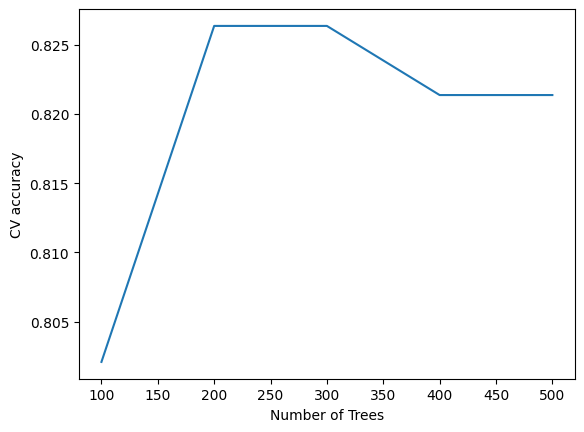

In [64]:
scores_cv = []
ntrees = [100, 200, 300, 400, 500]
for n in ntrees:
    scores = cross_val_score(
        RandomForestClassifier(n_estimators=n, max_features=4, random_state=0, bootstrap=True, oob_score=True, criterion='gini'),
        X_train,
        y_train,
        cv=5,
        scoring='accuracy'
    )
    scores_cv.append(scores.mean())

plt.plot(ntrees, scores_cv)
plt.xlabel('Number of Trees')
plt.ylabel('CV accuracy')
plt.show()

The 200 trees and 300 trees have same highest accuracy, we can use 200 trees to reduce computing time.

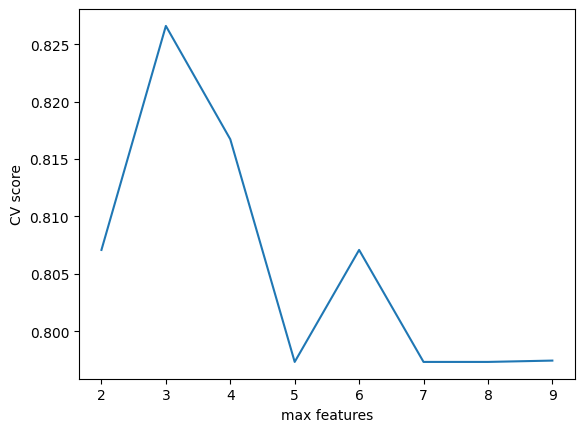

In [65]:
#  tune the number of predictors
scores_cv = []
m_feas = range(2,10)
for m_fea in m_feas:
    scores = cross_val_score(
        RandomForestClassifier (
    n_estimators = 200,
    max_features=m_fea,
    random_state=1,
    bootstrap=True,
    oob_score=True,
    criterion='gini'
    ),
                         X_train,
                         y_train,
                         cv=5,
                         scoring='accuracy')
    scores_cv.append(scores.mean())

plt.plot(m_feas, scores_cv)
plt.xlabel('max features')
plt.ylabel('CV score')
plt.show()

It seems the best number of predictors to use in each split is 3.

In [66]:
rf_1 = RandomForestClassifier (
    n_estimators = 200,
    max_features=3,
    random_state=1,
    bootstrap=True,
    oob_score=True,
    criterion='gini')

rf_1.fit(X_train, y_train)

RandomForestClassifier(max_features=3, n_estimators=200, oob_score=True,
                       random_state=1)

12. Use **forward selection** method.

In [67]:
sfs = SFS(
    rf_1,
    k_features=(1, 20),
    forward=True,
    floating=False,
    scoring='roc_auc',
    cv=5
    )
sfs = sfs.fit(X_train, y_train)

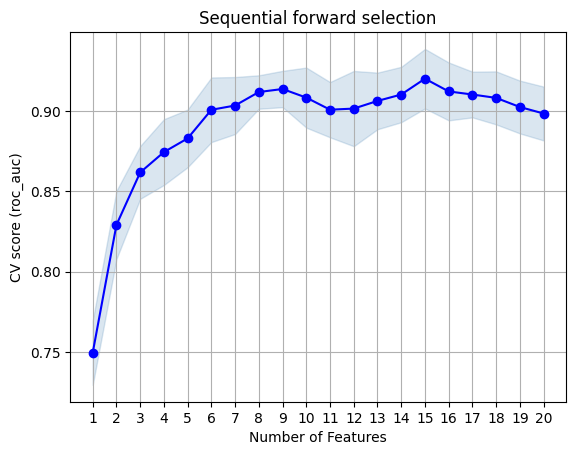

In [68]:
fig = plot_sfs(sfs.get_metric_dict(), kind='std_err')
plt.ylabel('CV score (roc_auc)')
plt.title('Sequential forward selection')
plt.grid()
plt.show()

In [69]:
#selected features based on forward selection
X_train.columns[list(sfs.k_feature_idx_)]

Index(['age', 'oldpeak', 'sex_1', 'cp_2', 'cp_4', 'fbs_1', 'restecg_1',
       'exang_1', 'slope_2', 'slope_3', 'thal_6.0', 'thal_7.0', 'ca_1.0',
       'ca_2.0', 'ca_3.0'],
      dtype='object')

In [70]:
#prediction on test set
sel_col = X_train.columns[list(sfs.k_feature_idx_)]
X_train_sfs = X_train[sel_col]
X_test_sfs = X_test[sel_col]

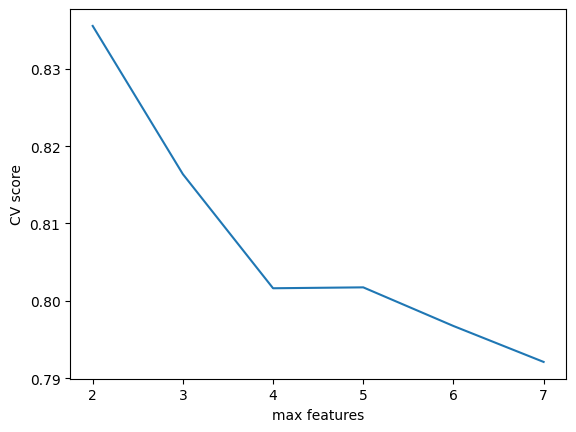

In [71]:
#  tune the number of predictors again since num of feature change
scores_cv = []
m_feas = range(2,8)
for m_fea in m_feas:
    scores = cross_val_score(
        RandomForestClassifier (
    n_estimators = 200,
    max_features=m_fea,
    random_state=1,
    bootstrap=True,
    oob_score=True,
    criterion='gini'
    ),
                         X_train_sfs,
                         y_train,
                         cv=5,
                         scoring='accuracy')
    scores_cv.append(scores.mean())

plt.plot(m_feas, scores_cv)
plt.xlabel('max features')
plt.ylabel('CV score')
plt.show()

Change number of predictors to 2.

In [72]:
sfs_rf = RandomForestClassifier (
    n_estimators = 200,
    max_features=2,
    random_state=1,
    bootstrap=True,
    oob_score=True,
    criterion='gini')

sfs_rf.fit(X_train_sfs, y_train)

RandomForestClassifier(max_features=2, n_estimators=200, oob_score=True,
                       random_state=1)

13.


*   For the first two classifiers using all features in Question 11, Random Forest predict more accurate than Lasso Logistic Regression.

*   For the first two classifiers using all features in Question 11, Random Forest have higher AUC score. According to the ROC curve, this is because Random Forest classifier better balances sensitivity and specificity across different classification thresholds.


*   Forward selection method used in question 12 improve both accuracy and AUC score of Random forest model.

In [73]:
pred_prob_lasso = m_lasso.predict_proba(X_test)
metrics_lasso = pd.DataFrame(
    data = {'prob_d': pred_prob_lasso[:,1], 'y_test': y_test}
    )
metrics_lasso['y_pred'] = metrics_lasso.prob_d.map(lambda x: 1 if x>0.5 else 0)
metrics_lasso.head(3)

,prob_d,y_test,y_pred
139,0.114360,0,0
236,0.962425,1,1
51,0.507286,0,1


In [74]:
# accuracy at threshold 0.5
lasso_accuracy = (metrics_lasso.y_test==metrics_lasso.y_pred).mean()

# AUC
lasso_auc = roc_auc_score(metrics_lasso.y_test, metrics_lasso.prob_d)

print(f'Accuracy of Lasso Logistic Regression: {lasso_accuracy}')
print(f'AUC score of Lasso Logistic Regression: {lasso_auc}')

Accuracy of Lasso Logistic Regression: 0.7777777777777778
AUC score of Lasso Logistic Regression: 0.8863750628456512


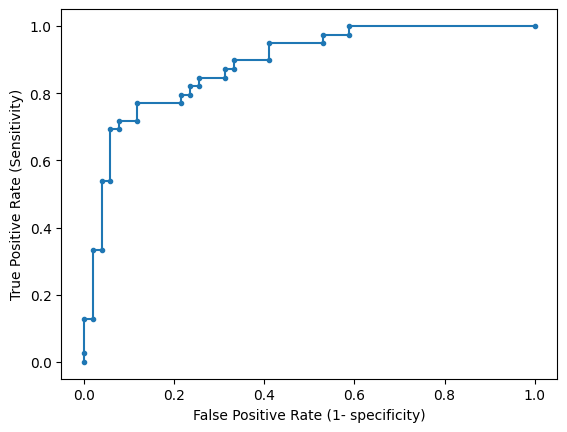

In [75]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(metrics_lasso.y_test, metrics_lasso.prob_d)
plt.plot(fpr, tpr, marker='.', label='Lasso Logistic Regression')
plt.xlabel('False Positive Rate (1- specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')

plt.show()

In [76]:
pred_prob_rf = rf_1.predict_proba(X_test)
metrics_rf = pd.DataFrame(
    data = {'prob_d': pred_prob_rf[:,1], 'y_test': y_test}
    )
metrics_rf['y_pred'] = metrics_rf.prob_d.map(lambda x: 1 if x>0.5 else 0)
metrics_rf.head(3)

,prob_d,y_test,y_pred
139,0.370,0,0
236,0.900,1,1
51,0.545,0,1


In [77]:
# accuracy at threshold 0.5
rf_accuracy = (metrics_rf.y_test==metrics_rf.y_pred).mean()

# AUC
rf_auc = roc_auc_score(metrics_rf.y_test, metrics_rf.prob_d)

print(f'Accuracy of Random Forest: {rf_accuracy}')
print(f'AUC score of Random Forest: {rf_auc}')

Accuracy of Random Forest: 0.8222222222222222
AUC score of Random Forest: 0.8976872800402212


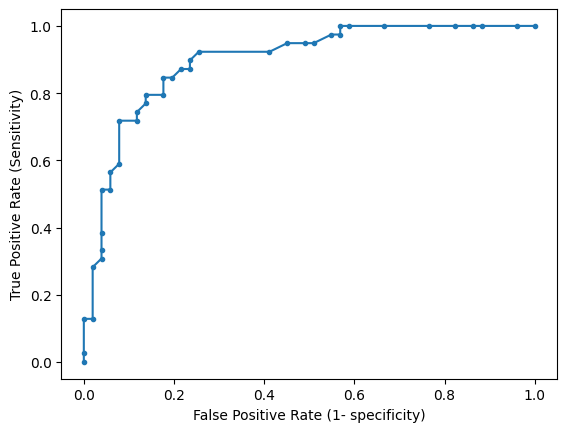

In [78]:
# ROC Curve
fpr2, tpr2, thresholds2 = roc_curve(metrics_rf.y_test, metrics_rf.prob_d)
plt.plot(fpr2, tpr2, marker='.', label='RF')
plt.xlabel('False Positive Rate (1- specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')

plt.show()

In [79]:
pred_prob_sfs = sfs_rf.predict_proba(X_test_sfs)
metrics_sfs = pd.DataFrame(
    data = {'prob_d': pred_prob_sfs [:,1], 'y_test': y_test}
    )
metrics_sfs['y_pred'] = metrics_sfs.prob_d.map(lambda x: 1 if x>0.5 else 0)

# accuracy at thrshold 0.5
sfs_accuracy = (metrics_sfs.y_test==metrics_sfs.y_pred).mean()

# AUC
sfs_auc = roc_auc_score(metrics_sfs.y_test, metrics_sfs.prob_d)

print(f'Accuracy of Random Forest(selected): {sfs_accuracy}')
print(f'AUC score of Random Forest(selected): {sfs_auc}')

Accuracy of Random Forest(selected): 0.8444444444444444
AUC score of Random Forest(selected): 0.901458019105078


14. The best model is the Random Forest classifer with forward selection `sfs_rf`.

 After considering the selected features based on forward selection, Random Forest importance, and Lasso coefficients, the most important predictor variables in the context of the classification challenge include `ca`, `sex`, `age`, `slope`, `oldpeak`, `thalach`, `thal`, `cp` , `chol`, `trestbps`and `fbs`.

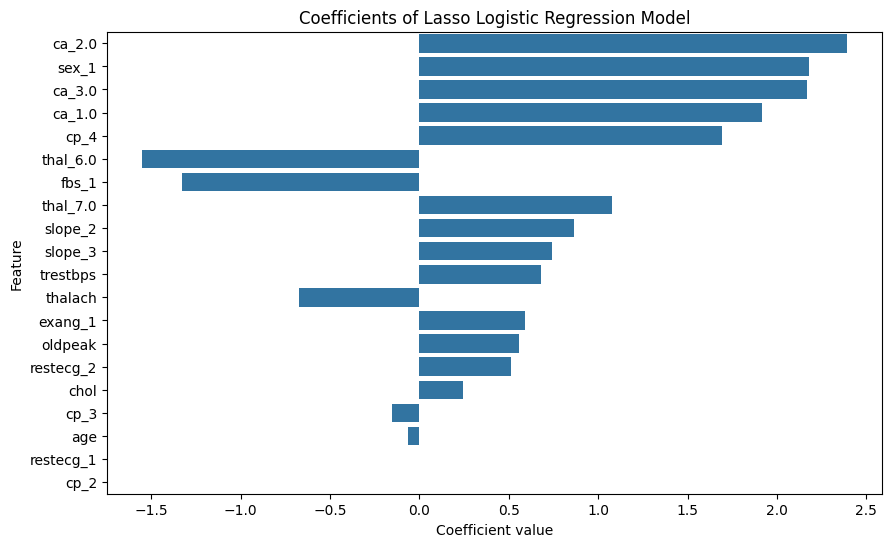

In [80]:
#coefficients
coefficients = m_lasso.coef_.reshape(len(X_train.columns))
feature_names = X_train.columns
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
# Sort coeff
coef_df['abs_coefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='abs_coefficient', ascending=False)

#coef plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=coef_df)
plt.title('Coefficients of Lasso Logistic Regression Model')
plt.xlabel('Coefficient value')
plt.ylabel('Feature')
plt.show()

Text(0.5, 1.0, 'Feature Importance of Random Forest Model')

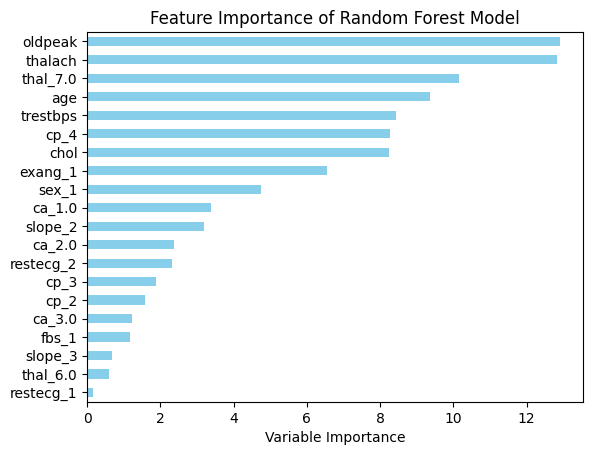

In [81]:
Importance = pd.DataFrame({'Importance':rf_1.feature_importances_*100}, index=X.columns)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='skyblue')
plt.xlabel('Variable Importance')
plt.gca().legend_ = None
plt.title('Feature Importance of Random Forest Model')

In [82]:
#selected features based on forward selection
X_train.columns[list(sfs.k_feature_idx_)]

Index(['age', 'oldpeak', 'sex_1', 'cp_2', 'cp_4', 'fbs_1', 'restecg_1',
       'exang_1', 'slope_2', 'slope_3', 'thal_6.0', 'thal_7.0', 'ca_1.0',
       'ca_2.0', 'ca_3.0'],
      dtype='object')

15. We used the dataset with the `cluster` variable from Question 7 to improve the Lasso Logistic Regression model (since the coefficients can help evaluate feature importance). However, both performance metrics unchanged. This may be due to the imbalanced `cluster` variable. Moreover, the coefficient of cluster is not zero, which means the variable may contribute to the model but no sample from `cluster = 1` is in the test set.

In [83]:
df_cluster = pd.get_dummies(df_cluster, columns=cat_col, drop_first=True, dtype=int)

df_cluster['cluster'] = df_cluster['cluster'].astype('int')

X_cluster = df_cluster.drop(columns = ['num'])
y_cluster = df_cluster['num']

scaler = StandardScaler()
X_cluster[num_col] = scaler.fit_transform(X_cluster[num_col])
print(X.head(3))

        age  trestbps      chol   thalach   oldpeak  sex_1  cp_2  cp_3  cp_4  \
0  0.936181  0.750380 -0.276443  0.017494  1.174672      1     0     0     0   
1  1.378929  1.596266  0.744555 -1.816334  0.645463      1     0     0     1   
2  1.378929 -0.659431 -0.353500 -0.899420  1.340529      1     0     0     1   

   fbs_1  restecg_1  restecg_2  exang_1  slope_2  slope_3  thal_6.0  thal_7.0  \
0      1          0          1        0        0        1         1         0   
1      0          0          1        1        1        0         0         0   
2      0          0          1        1        1        0         0         1   

   ca_1.0  ca_2.0  ca_3.0  
0       0       0       0  
1       0       0       1  
2       0       1       0  


In [84]:
X_cluster_train, X_cluster_test, y_cluster_train, y_cluster_test = train_test_split(
    X_cluster, y_cluster, test_size=0.3, random_state=1)

In [85]:
 # find λ
lasso_cv2 = LogisticRegressionCV(
    penalty='l1',
    solver='saga',
    cv=5,
    max_iter=10000,
    scoring='accuracy'
)
lasso_cv2.fit(X_cluster_train, y_cluster_train)


lasso_cluster = LogisticRegression(
    penalty='l1',
    C=lasso_cv2.C_[0],
    solver='saga',
    max_iter=10000
)
lasso_cluster.fit(X_cluster_train, y_cluster_train)

LogisticRegression(C=np.float64(2.782559402207126), max_iter=10000,
                   penalty='l1', solver='saga')

In [86]:
pred_prob_cluster = lasso_cluster.predict_proba(X_cluster_test)
metrics_cluster = pd.DataFrame(
    data = {'prob_d': pred_prob_cluster[:,1], 'y_test': y_cluster_test}
    )
metrics_cluster['y_pred'] = metrics_cluster.prob_d.map(lambda x: 1 if x>0.5 else 0)

# accuracy at therehold 0.5
cluster_accuracy = (metrics_cluster.y_test==metrics_cluster.y_pred).mean()

# AUC
cluster_auc = roc_auc_score(metrics_cluster.y_test, metrics_cluster.prob_d)

print(f'Accuracy of Random Forest(cluster): {cluster_accuracy}')
print(f'AUC score of Random Forest(cluster): {cluster_auc}')

Accuracy of Random Forest(cluster): 0.7777777777777778
AUC score of Random Forest(cluster): 0.8863750628456512


In [87]:
df_cluster['cluster'].value_counts()

cluster
0    292
1      5
Name: count, dtype: int64

Text(0, 0.5, 'Feature')

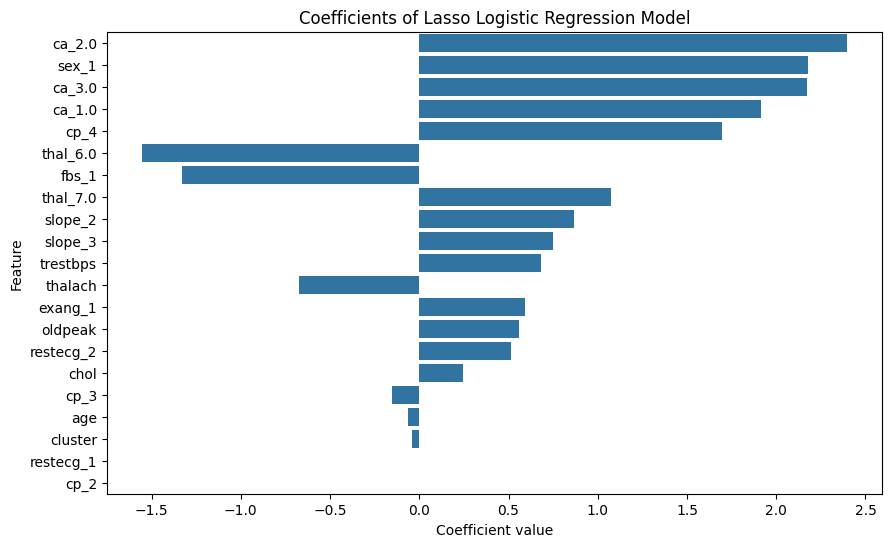

In [88]:
coefficients2 = lasso_cluster.coef_.reshape(len(X_cluster_train.columns))
feature_names2 = X_cluster_train.columns
coef_df2 = pd.DataFrame({'Feature': feature_names2, 'Coefficient': coefficients2})

coef_df2['abs_coefficient'] = coef_df2['Coefficient'].abs()
coef_df2 = coef_df2.sort_values(by='abs_coefficient', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=coef_df2)
plt.title('Coefficients of Lasso Logistic Regression Model')
plt.xlabel('Coefficient value')
plt.ylabel('Feature')

16. 
* Bingyue Sun: Questions 1,2,3,4,5,6,7,8
* Xiaoxiao Fan: Questions 9,10,11,12,13,14,15

## References

- [Janosi, A., Steinbrunn, W., Pfisterer, M., & Detrano, R. (1989). Heart Disease [Dataset]. UCI Machine Learning Repository.](https://doi.org/10.24432/C52P4X).


- xgboost_application reference lecture. [Lab notes].
- 02-clustering-examples. [Lecture notes].
- 02-Clustering-applications.[Lecture notes].
- 03-PCA-impution.[Lecture notes].
- 02-subset-sel-example. [Lecture notes].
- 02-bagging-RF-boosting-example. [Lecture notes].
- 01-data-viz1. [Lecture notes].
- 02-shrinkage-example. [Lecture notes].
- 02-logistic-regression-example. [Lecture notes].
- linear-regression-application-subgroup. [Lab notes].
- ensemble-application. [Lab notes].
- logistic-regression-application. [Lab notes].
